In [101]:
# load all previous fake news domains for retrospective analysis and visualization to identify suspicious clusters
# need to introduce certain thresholds
# visualize domain redirection chain with d3js

import os
import json
from pprint import pprint
from urllib.parse import urlparse
import util
from collections import defaultdict, Counter

def get_redirection_chain(document, edge_type):
    has_frontend_redirect = False
    previous_url = urlparse(document['url']).netloc
    # 1. init sub_redirect_chain with the first level URL
    sub_redirect_chain = [previous_url]
    
    # we need a map of url --> ip
    url_ip_map = {}
    for entry in document["network_communication"]:
        # check if remoteIPAddress points to NYU IP (no such case find)
        if '216.165' in entry['remoteIPAddress']:
            pprint(entry)
        normalized_url = util.get_normalized_domain(entry['url'])
        url_ip_map[normalized_url] = entry['remoteIPAddress']
        
    for index, chain in enumerate(document["redirection_chain"]):
        method = chain['method']
        
        if method == 'Page.frameScheduledNavigation':
            url_domain = urlparse(chain['url']).netloc
            if url_domain != previous_url:
                edge_type[(sub_redirect_chain[-1], url_domain)] = 'client_side'
                sub_redirect_chain.append(url_domain)
                has_frontend_redirect = True
            previous_url = urlparse(chain['url']).netloc

        if method == 'Network.requestWillBeSent':
            url_from = urlparse(chain['from_url']).netloc
            url_to = urlparse(chain['to_url']).netloc
            if url_from == previous_url and url_from != url_to:
                edge_type[(sub_redirect_chain[-1], url_to)] = 'server_side'
                sub_redirect_chain.append(url_to)
                previous_url = url_to
    
    return has_frontend_redirect, url_ip_map, sub_redirect_chain, document["network_communication"]

prefix = 'novelepoxy'
# prefix = 'cnnews3_com'
directory = '/Users/zc/Documents/TwitterBotProject/malicious_domain/{}/'.format(prefix)
graph_type = 'domain'  # domain | ip


nodes = {}
links = defaultdict(int)
counter = 0
no_ip = 0
no_redirect = 0
has_redirect = 0
last_domain = set([])
first_domain = set([])
temp_count = 0
valid_first_ips = defaultdict(list)
in_degree = Counter()
domain_status = {}
import re
phrase = re.compile('ww[0-9]+')
import os
import glob
glitch_subdomain = set([])

for filename in os.listdir(directory):
    # load trace.json if it exists
    if os.path.isfile('{}/{}/trace.json'.format(directory, filename)):
        trace = json.load(open('{}/{}/trace.json'.format(directory, filename), 'r'))
        if any([r['is_redirect'] for r in trace['record']]):
                final_chain = []
                domain_ip = {}
                for r in trace['record']:
                    _, url_ip_map, res, net_comm = get_redirection_chain(r['record'], {})
                    if len(final_chain) == 1 and final_chain[0] == res[0]:
                        final_chain = res
                        domain_ip = url_ip_map
                    else:
                        final_chain += res
                        domain_ip.update(url_ip_map)
                        
                # skip non-redirection chains
                final_chain = [url.replace('www.', '') for url in final_chain]
                if len(final_chain) < 2:
                    print('WRONG DATA FORMAT')
                    pprint(final_chain)
                    domain_status[trace['input_url']] = 'other_error'
                    continue
                    
                if len(final_chain) == 2 and final_chain[-1] == final_chain[-2]:
                    no_redirect += 1
                    domain_status[trace['input_url']] = 'no_redirect'
                    continue
                        
                ##### translate domains to IPs ###############
                if graph_type == 'ip':
                    new_final_chain = []
                    pass_url = False
                    for url in final_chain:
                        if url not in domain_ip:
                            print("NO URL: ", url)
                            new_final_chain.append(str(temp_count))
                            temp_count += 1
                            pass_url = True
                        else:
                            new_final_chain.append(domain_ip[url])

                    if pass_url:
                        continue
                    final_chain = new_final_chain
            
#                 final_chain = [domain_ip[url.replace('www.', '')] for url in final_chain]
                #############################################
                
                # reformat final_chain to remove cycles
                previous_url = defaultdict(int)
                new_final_chain = []
                for url in final_chain:
                    num = previous_url[url]
                    if num == 0:
                        new_final_chain.append(url)
                    else:
                        new_final_chain.append('{}_LOOP_{}'.format(url, num))
                    previous_url[url] += 1
                
                # add node, edge
                if 'click.bounceads.net' not in new_final_chain:
#                     print(new_final_chain)
                    html_file = trace['record'][0]['record']['source_filename']
                    with open(html_file, 'r') as file:
                        text = file.read()
                        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)

                        if len(urls) == 0:
                            print(filename)
                        else:
                            for url in urls:
                                if 'glitch' in url:
                                    print(url)
                                    glitch_subdomain.add(url)
#                             pprint(urls)

#                         for url in urls:
#                             if 'chrome.google.com' in url and 'google-analytics' not in url \
#                             and 'webstore/reviews' not in url and 'webstore/ajax/' not in url\
#                             and 'cws-static' not in url and 'accounts.google.com' not in url\
#                             and 'webstore/category' not in url and 'extensions/permalink' not in url\
#                             and 'detail' in url:
#                                 chrome_url[url] += 1
        
    
                final_chain = new_final_chain

                if len(final_chain) != len(set(final_chain)):
                    print('duplicate detected!')
                
#                 ## identify high in-degree nodes
#                 suspicious_domains = {'4179.roberat.com',
#                  '5751.roberat.com',
#                  'bidr.trellian.com',
#                  'domain.dot.tk',
#                  'dprtb.com',
# #                  'instagram.com',
#                  'park.above.com',
# #                  'politicono.com',
#                  'usa.jared-don.com',
#                  'usd.jared-don.com'}

#                 if len(set(final_chain).intersection(suspicious_domains)) == 0:
#                     continue
                    
                for index, url in enumerate(final_chain[:-1]): 
                    if url not in nodes:
                        nodes[url] = counter
                        counter += 1
                    if final_chain[index+1] not in nodes:
                        nodes[final_chain[index+1]] = counter
                        counter += 1
                    links[(nodes[url], nodes[final_chain[index+1]])] += 1
                in_degree[final_chain[1]] += 1
                has_redirect += 1
                domain_status[trace['input_url']] = 'has_redirect'
        
                
    else:
        print('trace does not exist')
        print(filename)

        
# we need to direct cycles
# what algorithm is efficient?
# https://www.geeksforgeeks.org/detect-cycle-in-a-graph/
# we need to find the exact path that has cycle
from collections import defaultdict 
  
class Graph(): 
    def __init__(self,vertices): 
        self.graph = defaultdict(list) 
        self.V = vertices 
  
    def addEdge(self,u,v): 
        self.graph[u].append(v) 
  
    def isCyclicUtil(self, v, visited, recStack): 
  
        # Mark current node as visited and  
        # adds to recursion stack 
        visited[v] = True
        recStack[v] = True
  
        # Recur for all neighbours
        # if any neighbour is visited and in  
        # recStack then graph is cyclic 
        for neighbour in self.graph[v]: 
            if visited[neighbour] == False: 
                if self.isCyclicUtil(neighbour, visited, recStack) == True: 
                    print(v, neighbour)
                    return True
            elif recStack[neighbour] == True: 
                return True
  
        # The node needs to be poped from  
        # recursion stack before function ends 
        recStack[v] = False
        return False
  
    # Returns true if graph is cyclic else false 
    def isCyclic(self): 
        visited = [False] * self.V 
        recStack = [False] * self.V 
        for node in range(self.V): 
            if visited[node] == False: 
                if self.isCyclicUtil(node,visited,recStack) == True: 
                    return True
        return False

# nodes
# links
# we need a reverse dictionary
g = Graph(len(nodes)) 
for key in links:
    g.addEdge(key[0], key[1]) 

if g.isCyclic() == 1: 
    print("Graph has a cycle")
else: 
    print("Graph has no cycle")

total = no_redirect + has_redirect + no_ip
print(no_redirect, no_redirect / total, no_redirect / (no_redirect + has_redirect))
print(has_redirect, has_redirect / total, has_redirect / (no_redirect + has_redirect))
print(no_ip, no_ip / total)


https___vnxhgsxw_novelepoxy_com_r__ci=5095
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=26642547105695490
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=26642547105695490
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=26642547105695490
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=42819629162198504
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=42819629162198504
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=42819629162198504
https://pastoral-pear-butterkase.glitch.me

https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66884408231097832
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66884408231097832
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66884408231097832
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66884408231097832
https://keen-talented-starfish.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=33857488409359848
https://keen-talented-starfish.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=33857488409359848
https://keen-talented-starfish.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-

https://ubiquitous-kindhearted-century.glitch.me/s7/Install.zip?title=Player&amp;clickid=32502933033612776
https___vnxhgsxw_novelepoxy_com_r__ci=5177
https___vnxhgsxw_novelepoxy_com_r__ci=5183
https___vnxhgsxw_novelepoxy_com_r__ci=5373
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=39481050461996802
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=39481050461996802
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=39481050461996802
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=39481050461996802
trace does not exist
.DS_Store
https://gainful-shaded-jeep.glitch.me/s7/Install.zip?title=Player&amp;clickid=27769617080415720
https___vnxhgsxw_

https___vnxhgsxw_novelepoxy_com_r__ci=6700
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=49699593702967042
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=49699593702967042
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=49699593702967042
https://noiseless-animated-laugh.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=11274539940284162
https://noiseless-animated-laugh.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=11274539940284162
https://noiseless-animated-laugh.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=11274539940284162
https://busy-uncovered-carp.glitch.me/s7/AdobeFl

https___vnxhgsxw_novelepoxy_com_r__ci=5702
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=36511660397397762
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=36511660397397762
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=36511660397397762
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=36511660397397762
https://gray-vagabond-anise.glitch.me/s/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=1942819088397800
https://gray-vagabond-anise.glitch.me/s/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=1942819088397800
https://gray-vagabond-anise.glitch.me/s/Ado

https://hissing-pewter-uranium.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66580189565781762
https://hissing-pewter-uranium.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66580189565781762
https://hissing-pewter-uranium.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66580189565781762
https://hissing-pewter-uranium.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=66580189565781762
https___vnxhgsxw_novelepoxy_com_r__ci=5087
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=2494630354847490
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=2494630354847490
https://grandiose-smooth-ship.glitch.me/s7/AdobeF

https___vnxhgsxw_novelepoxy_com_r__ci=4966
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=68438963053950440
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=68438963053950440
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=68438963053950440
https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=68438963053950440
https___vnxhgsxw_novelepoxy_com_r__ci=6632
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=29940276371944936
https://pastoral-pear-butterkase.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=29940276371944936
https://pa

https://tasty-ionian-dracopelta.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=63658709861369602
https://tasty-ionian-dracopelta.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=63658709861369602
https://tasty-ionian-dracopelta.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=63658709861369602
https://tasty-ionian-dracopelta.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=63658709861369602
https://cobalt-absorbing-football.glitch.me/s7/Install.zip?title=super-vpn&amp;clickid=16611320273405698
https://cobalt-absorbing-football.glitch.me/s7/Install.zip?title=super-vpn&amp;clickid=16611320273405698
https://cobalt-absorbing-football.glitch.me/s7/Install.zip?title=super-vpn&amp;clickid=16611320273405698
https://happy-tortoiseshell-authority.glitch.me/s7/AdobeFlashPlayer.zip?s

https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=6557317229545218
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=6557317229545218
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=6557317229545218
https://pastoral-pear-butterkase.glitch.me/s/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=21186853849822696
https://pastoral-pear-butterkase.glitch.me/s/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=21186853849822696
https://pastoral-pear-butterkase.glitch.me/s/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=21186853849822696
https://pastoral-pear-butterkase.glitch.me/s/AdobeFlashPlayer.zip?software=flash-player-ppa

https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=8727289326307074
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=8727289326307074
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=8727289326307074
https://cobalt-absorbing-football.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=8727289326307074
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=68920238072497922
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=68920238072497922
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-pla

https://busy-uncovered-carp.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=33877704820422120
https://ubiquitous-kindhearted-century.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=29392620797064680
https://ubiquitous-kindhearted-century.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=29392620797064680
https://ubiquitous-kindhearted-century.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=29392620797064680
https://ubiquitous-kindhearted-century.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=29392620797064680
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.zip?software=flash-player-ppapi&amp;title=flash-player-ppapi&amp;clickid=15090283375331074
https://grandiose-smooth-ship.glitch.me/s7/AdobeFlashPlayer.

In [103]:
from urllib.parse import urlparse, urlsplit
glitch_subdomain_2 = set([])
for url in glitch_subdomain:
    netloc = urlsplit(url).netloc
    path = urlsplit(url).path
    glitch_subdomain_2.add((netloc))

pprint(glitch_subdomain_2)

{'busy-uncovered-carp.glitch.me',
 'cobalt-absorbing-football.glitch.me',
 'cubic-fluffy-adjustment.glitch.me',
 'gainful-shaded-jeep.glitch.me',
 'grandiose-smooth-ship.glitch.me',
 'gray-vagabond-anise.glitch.me',
 'happy-tortoiseshell-authority.glitch.me',
 'hissing-pewter-uranium.glitch.me',
 'keen-talented-starfish.glitch.me',
 'noiseless-animated-laugh.glitch.me',
 'pastoral-pear-butterkase.glitch.me',
 'tasty-ionian-dracopelta.glitch.me',
 'ubiquitous-kindhearted-century.glitch.me'}


In [5]:
import pandas as pd
# df_dns = pd.read_csv('')
import jsonlines

with jsonlines.open('/Users/zc/Documents/suspicious_domain_redirection_campaign_dns_history.jsonl') as reader:
    dns_record = [obj for obj in reader]

with jsonlines.open('/Users/zc/Documents/suspicious_domain_fake_news_concat_dns_history.jsonl') as reader:
    concat_record = [obj for obj in reader]
    seed_domain = [(r['url'], r['record']) for r in concat_record]


In [6]:
campaign_1 = [(r['url'], r['record'][0:2]) for r in dns_record if r['campaign_id'] == 1]

manual_collected_whois = [
('allaboutusa.pro', [['N/A', 'BLUEHOST.COM', '11 Nov 2019', '2019-12-01', 'New']]),
('maga2020.pro', [['N/A', 'BLUEHOST.COM', '18 Dec 2019', '2020-01-01', 'New']]),
('2020maga.pro', [['N/A', 'BLUEHOST.COM', '25 Dec 2019', '2020-01-01', 'New']]),
('ilmaga.pro', [['N/A', 'BLUEHOST.COM', 'Dec 25 2019', '2020-01-01', 'New']]),
('magasupport.pro', [['N/A', 'BLUEHOST.COM', 'Dec 25 2019', '2020-01-01', 'New']]),
('maganews.pro', [['N/A', 'BLUEHOST.COM', 'Dec 25 2019', '2020-01-01', 'New']]),
('magaltd.pro', [['N/A', 'BLUEHOST.COM', 'Jan 1 2020', '2020-02-01', 'New']]),
('nycpost.pro', [['N/A', 'BLUEHOST.COM', 'Jan 6 2020', '2020-02-01', 'New']]),
('newsmedia2020.pro', [['N/A', 'BLUEHOST.COM', 'Jan 9 2020', '2020-02-01', 'New']]),
('newstv5.pro', [['N/A', 'BLUEHOST.COM', 'Jan 11 2020', '2020-02-01', 'New']]),
('2020medianews.pro', [['N/A', 'BLUEHOST.COM', 'Jan 11 2020', '2020-02-01', 'New']]),
('trumpmaga.pro', [['N/A', 'BLUEHOST.COM', 'Feb 22 2020', '2020-03-01', 'New']]),
('usaonlinearticles.pro', [['N/A', 'BLUEHOST.COM', 'Feb 22 2020', '2020-03-01', 'New']]),
('coservativesfortrump.pro', [['N/A', 'BLUEHOST.COM', 'Feb 22 2020', '2020-03-01', 'New']]),
('conservativefeed.pro', [['N/A', 'BLUEHOST.COM', 'Feb 22 2020', '2020-03-01', 'New']])
]
                        
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 

In [7]:
campaign_2 = [r['record'][0:2] for r in dns_record if r['campaign_id'] == 2]

In [8]:
campaign_3 = [r['record'][0:2] for r in dns_record if r['campaign_id'] == 3]

In [97]:
from collections import Counter
import datetime
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def top_sequence(domain_list, return_type=None, verbose=False):
    c = Counter()
    cc = Counter()
    status = []
    domain_to_return = []
    for domain in domain_list:
        
        if len(domain[1]) == 1:
            cc[(domain[1][0][1], domain[1][0][0])] += 1
            c[(domain[1][0][-1], 'N/A')] += 1
            
        elif len(domain[1]) > 1:
            cc[(domain[1][0][1], domain[1][0][0])] += 1
            c[(domain[1][0][-1], domain[1][1][-1])] += 1

            if return_type and domain[1][0][-1] == return_type and verbose:
                pprint(domain)
            
#             if return_type is not None and domain[1][1][-1] == return_type:
#                 domain_to_return.append(domain[0])

            if return_type == 'New_Transfer':
                if domain[1][1][-1] == 'New' and domain[1][0][-1] == 'Transfer':
                    domain_to_return.append(domain[0])
            elif return_type == 'Transfer_Transfer':
                if domain[1][1][-1] == 'Transfer' and domain[1][0][-1] == 'Transfer':
                    domain_to_return.append(domain[0])
            elif return_type == 'Deleted_New':
                if domain[1][1][-1] == 'Deleted' and domain[1][0][-1] == 'New':
                    domain_to_return.append(domain[0])
            else:
                raise Exception('return type {} is not supported'.format(return_type))
            
            pre_date = datetime.datetime.strptime(domain[1][0][-2], "%Y-%m-%d")
            cur_date = datetime.datetime.strptime(domain[1][1][-2], "%Y-%m-%d")
            status.append({'date': [pre_date, cur_date],
                           'status': [domain[1][1][-1], domain[1][0][-1]]})     
    
    pprint(c.most_common())
    pprint(cc.most_common())
    return {'status_count': c.most_common(), 'dns_count': cc.most_common(), 'domain_status': status, 'return_domain': domain_to_return}

status_map = {'New': 'green', 'Deleted': 'black', 'Transfer': 'blue'}
import matplotlib.pyplot as plt
def viz_dns_status(time_series):
        # plt.legend()
        # plt.xlabel("number of hours after 11/01/2019")
        plt.figure(figsize=(14, 20))
        time_series = sorted(time_series, key=lambda x: x['date'])
#         [500:]
#         [400:400+150]
#         DAY_BASE = datetime.datetime.strptime('2015-01-01', "%Y-%m-%d")
        DAY_BASE = time_series[0]['date'][1]
        print(DAY_BASE)
        for index, val in enumerate(time_series):
            date = val['date']
            status = val['status']
            series = [((d.year - DAY_BASE.year) * 12) + d.month - DAY_BASE.month for d in date]
            y = [index] * len(series)
#             print(y, series)
            plt.scatter(y, series, marker='o', color=[status_map[s] for s in status], s=5)
#         plt.ylim(bottom=-0.2)
        plt.xlabel("month")
        plt.ylabel("timeline of each tweet")
#         plt.title('Post pattern on {}, group by {}'.format(platform, group_by_str))
#         plt.savefig('{}/{}_spread_time_{}'.format(prefix, platform, group_by_str), bbox_inches='tight')
        
#         patches = []
#         for label, color in colormap.items():
#              patches.append(mpatches.Patch(color=color, label=label))
#         plt.legend(handles=patches)

        plt.show()

# viz_dns_status([[1, 4, 5], [2, 4, 5]])


In [10]:
# 
domain_2 = [(r['url'], r['record']) for r in dns_record if r['campaign_id'] == 2 and r['record'] != [] and r['record'][0][1] == 'ABOVE.COM']
domain_3 = [(r['url'], r['record']) for r in dns_record if r['campaign_id'] == 3 and r['record'] != [] and r['record'][0][1] == 'DNSNUTS.COM']
domain_1 = [(r['url'], r['record']) for r in dns_record if r['campaign_id'] == 1 and r['record'] != []] + manual_collected_whois
# print(not_new)

result = top_sequence(domain_2)

# viz_dns_status(result['domain_status'])


[(('New', 'Deleted'), 530),
 (('Transfer', 'New'), 119),
 (('Transfer', 'Transfer'), 78)]
[(('ABOVE.COM', 'N/A'), 530),
 (('ABOVE.COM', 'BODIS.COM'), 55),
 (('ABOVE.COM', 'PARKINGCREW.NET'), 32),
 (('ABOVE.COM', 'JINMI.COM'), 25),
 (('ABOVE.COM', 'DSREDIRECTION.COM'), 21),
 (('ABOVE.COM', 'NAMEBRIGHTDNS.COM'), 16),
 (('ABOVE.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('ABOVE.COM', 'XZ.COM'), 8),
 (('ABOVE.COM', 'KQW.COM'), 8),
 (('ABOVE.COM', 'FASTDOMAIN.COM'), 3),
 (('ABOVE.COM', 'DRAGONPARKING.COM'), 3),
 (('ABOVE.COM', 'SERVERSEASY.NET'), 1),
 (('ABOVE.COM', 'MOCHAHOST.COM'), 1),
 (('ABOVE.COM', 'A2HOSTING.COM'), 1),
 (('ABOVE.COM', 'HOSTICAN.COM'), 1),
 (('ABOVE.COM', 'HOSTUPON.COM'), 1),
 (('ABOVE.COM', 'HOSTING24.COM'), 1),
 (('ABOVE.COM', 'BLUEHOST.COM'), 1),
 (('ABOVE.COM', 'HOSTEASE.COM'), 1),
 (('ABOVE.COM', 'ANHOSTING.COM'), 1),
 (('ABOVE.COM', 'NAMEPAL.COM'), 1),
 (('ABOVE.COM', 'NDOVERDRIVE.COM'), 1),
 (('ABOVE.COM', 'DYNADOT.COM'), 1),
 (('ABOVE.COM', 'PHEENIXAUCTIONS.COM'), 

In [11]:
# dic_hop = defaultdict(list)
# for i in seed_domain:
#     if i[2] != []:
#         dic_hop[i[1]].append((i[2][0][1], i[0]))

# pprint(dic_hop)
# pprint(seed_domain)

domain_1_time = dict([(r[0], r[1][0][-2].replace('-', '') + '000000') for r in domain_1]) 
domain_2_time = dict([(r[0], r[1][0][-2].replace('-', '') + '000000') for r in domain_2]) 
domain_3_time = dict([(r[0], r[1][0][-2].replace('-', '') + '000000') for r in domain_3]) 
domain_dns_change_time = {**domain_1_time, 
                          **domain_2_time, 
                          **domain_3_time}



In [12]:

# import json
# campaign_1 = json.load(open('/Users/zc/Documents/TwitterBotProject/MonitorWebApp/templates/sankey_nycpost_pro.json', 'r'))

# csv_result = []
# for node in campaign_1['nodes']:
#     if node['tier'] == 'tier_1':
#         print(node)
#         csv_result.append({
#             'url': node['name'],
#             'campaign_id': '1'
#         })
        
# d = pd.DataFrame(csv_result)
# d.to_csv('/Users/zc/Documents/suspicious_domain_campaign_one.csv')

# 2020medianews.pro
# 11 Jan, 2020
# Domain created*, nameservers added

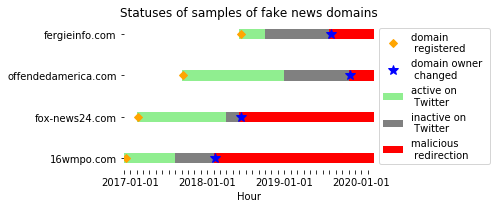

In [16]:
import datetime
import matplotlib.pyplot as plt

jobs = ['16wmpo.com', 'fox-news24.com', 'offendedamerica.com','fergieinfo.com']

# 2017-02-14 

DAY_BASE = datetime.datetime.strptime('2016-12-01', "%Y-%m-%d")
# input wait times
# converting wait times to float

import numpy as np
def time_to_int(ls):
    int_ls = []
    for d in ls:
        d = datetime.datetime.strptime(d, "%Y-%m-%d")
        int_ls.append((d.year - DAY_BASE.year) * 12 + d.month - DAY_BASE.month)
    return np.array(int_ls)

first_tweets = time_to_int(['2016-12-01', '2017-02-01', '2017-09-01', '2018-06-01'])

last_tweets = time_to_int(['2017-08-01', '2018-04-01', '2019-01-01', '2018-10-01'])

domain_change = time_to_int(['2018-02-01', '2018-06-01', '2019-11-01', '2019-08-01'])

current_time = time_to_int(['2020-03-01', '2020-03-01', '2020-03-01', '2020-03-01'])
    
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)

patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]


ax.barh(jobs, last_tweets - first_tweets, align='center', height=.25, color='lightgreen',label='active on \n Twitter', left=first_tweets)
ax.barh(jobs, domain_change - last_tweets, align='center', height=.25, left=last_tweets, color='grey',label='inactive on \n Twitter')
ax.barh(jobs, current_time - domain_change, align='center', height=.25, left=domain_change, color='r',label='malicious \n redirection')
ax.set_yticks(jobs)
ax.set_xlabel('Hour')
ax.set_title('Statuses of samples of fake news domains')
# ax.grid(True)

# plt.scatter(y=[2, 2, 2], x = [2, 14, 2.5], marker='D')
import numpy as np
# rng = np.random.RandomState(0)
plt.plot([0.3, 2.2, 9.2, 18.2], [0, 1, 2, 3], 'D',
             label="domain \n registered", c='orange')

plt.plot([14.2, 18.2, 35.2, 32.2], [0, 1, 2, 3], '*',
             label="domain owner \n changed", c='blue', markersize=10)

plt.box(False)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# overwrite x-axis label

# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(len(labels))
# labels[1] = 'Testing'

# group_labels = ['control', 'cold treatment',
#              'hot treatment', 'another treatment',
#              'the last one']

# ax.set_xticklabels(group_labels)
ax.set_xlim((0, 39))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1))
labels = [''] * 39
labels[1] = '2017-01-01'
labels[13] = '2018-01-01'
labels[25] = '2019-01-01'
labels[37] = '2020-01-01'
ax.set_xticklabels(labels)

plt.tight_layout()
plt.savefig('status_change_four_fake_news_domains')
plt.show()



In [17]:
# WHOIS history analysis

with jsonlines.open('/Users/zc/Documents/TwitterBotProject/suspicious_domain_whois.jsonl') as reader:
    whois_record = [obj for obj in reader]



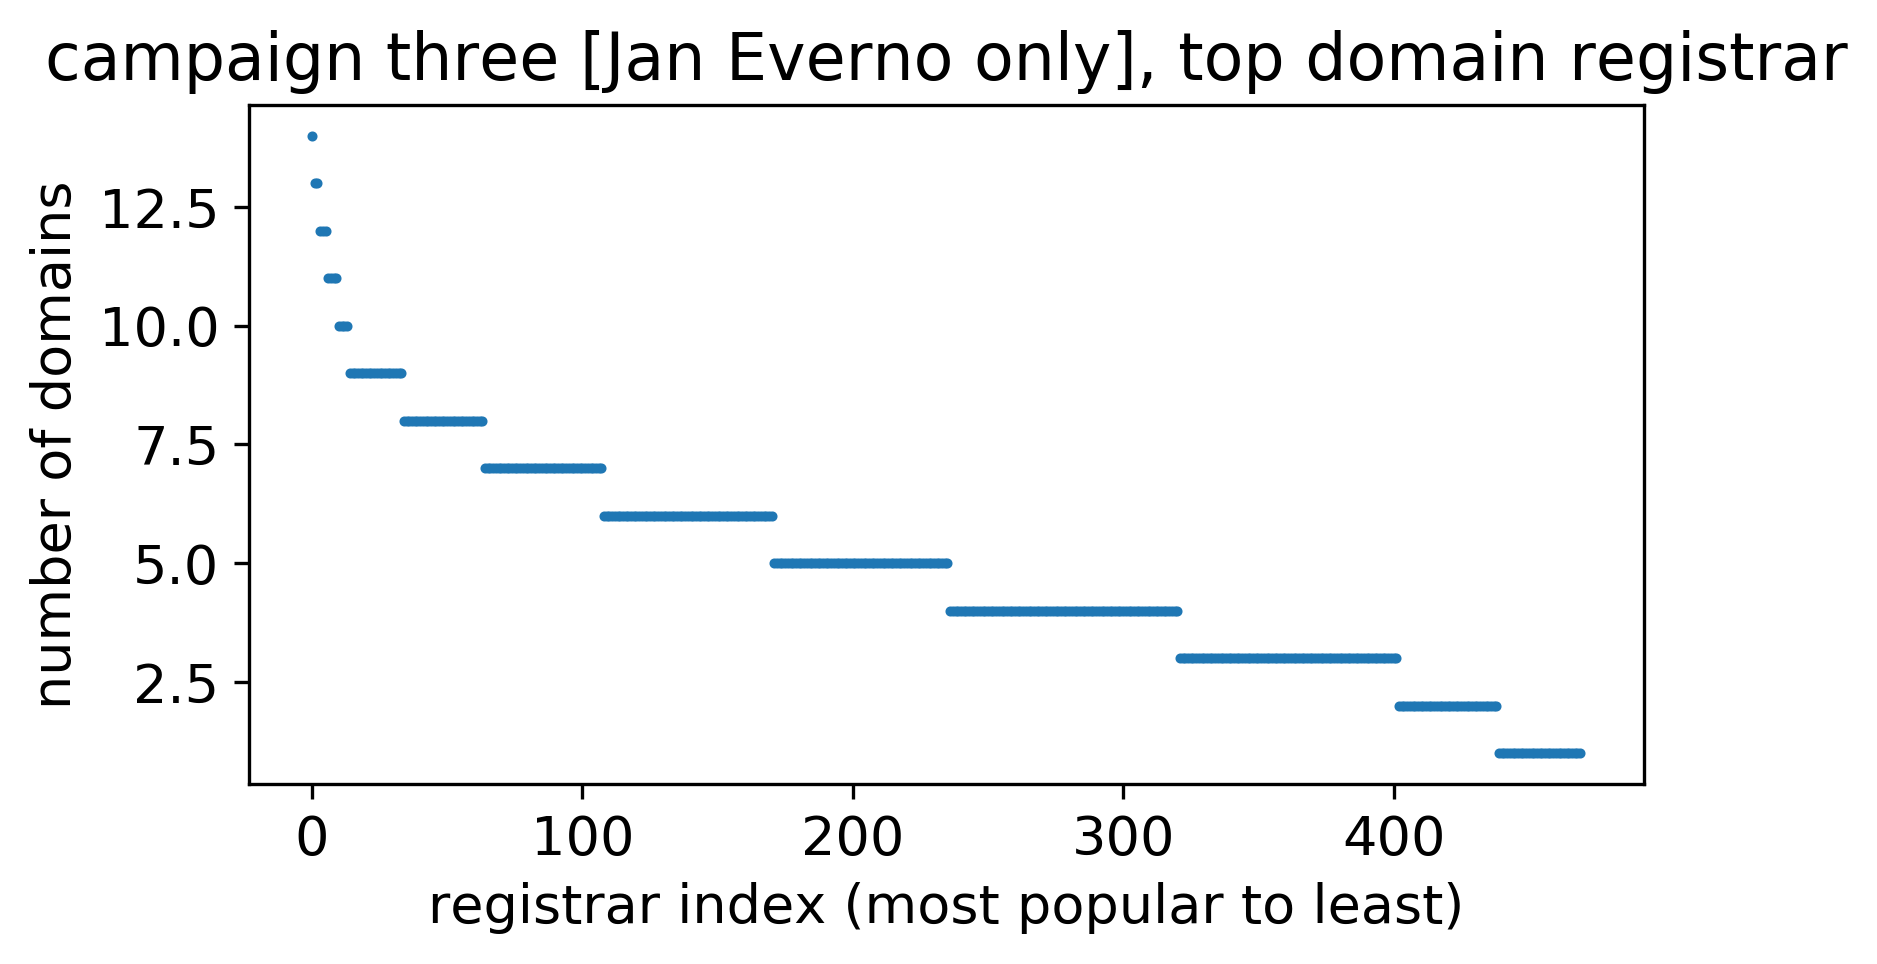

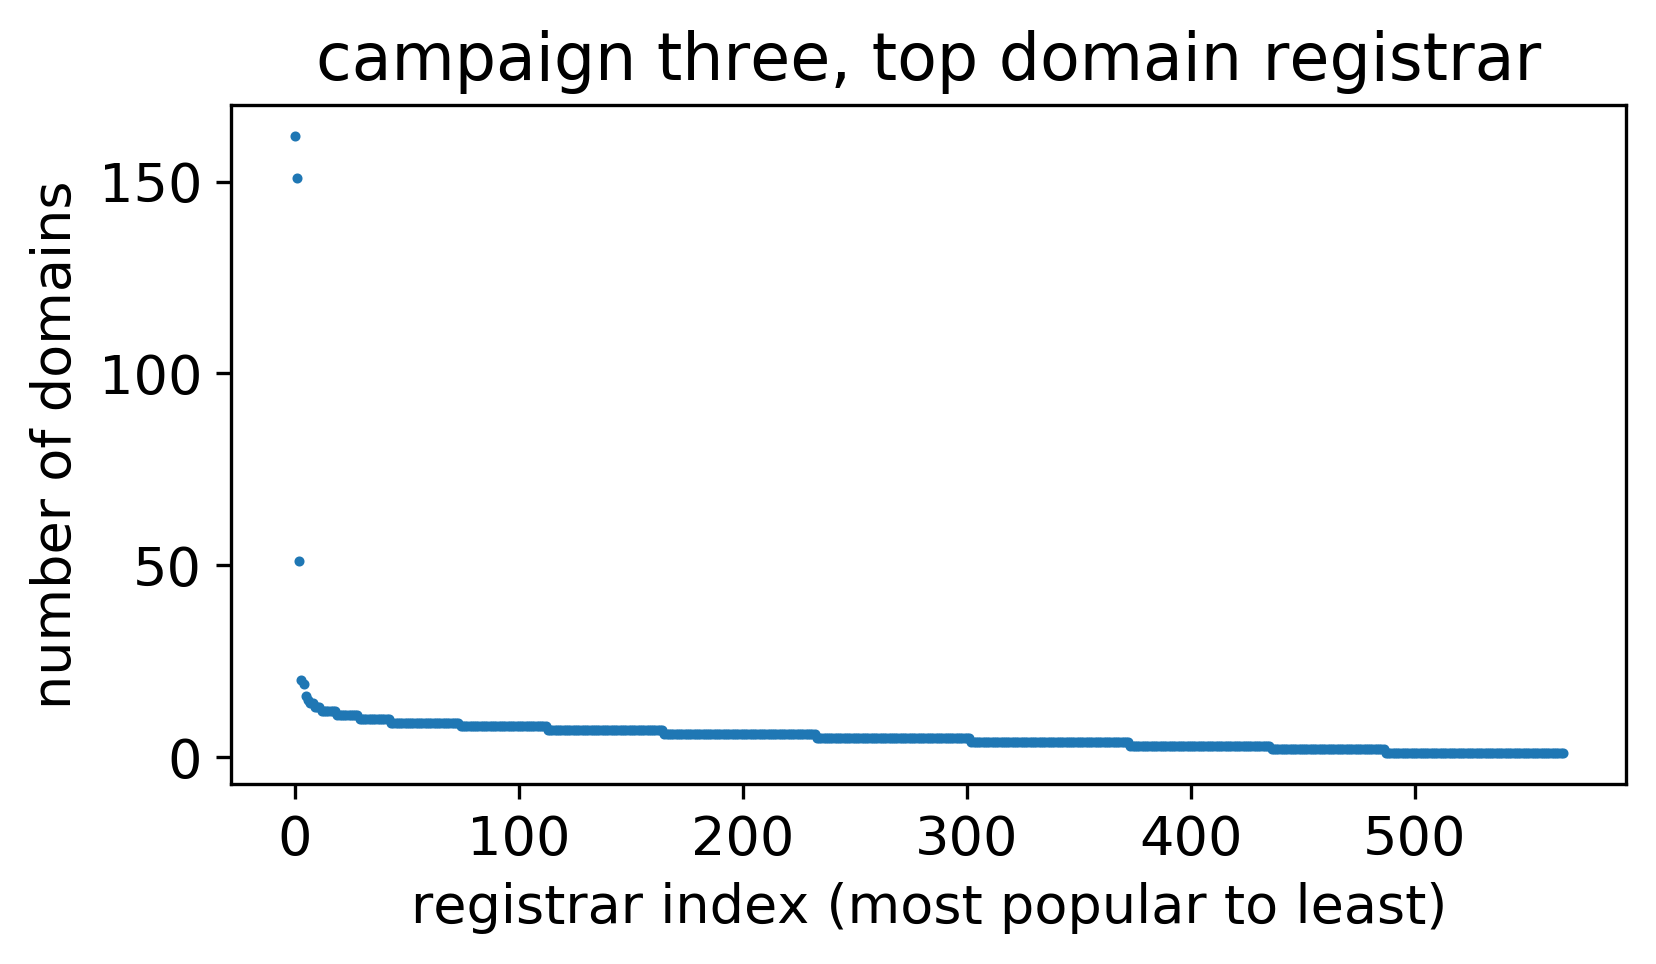

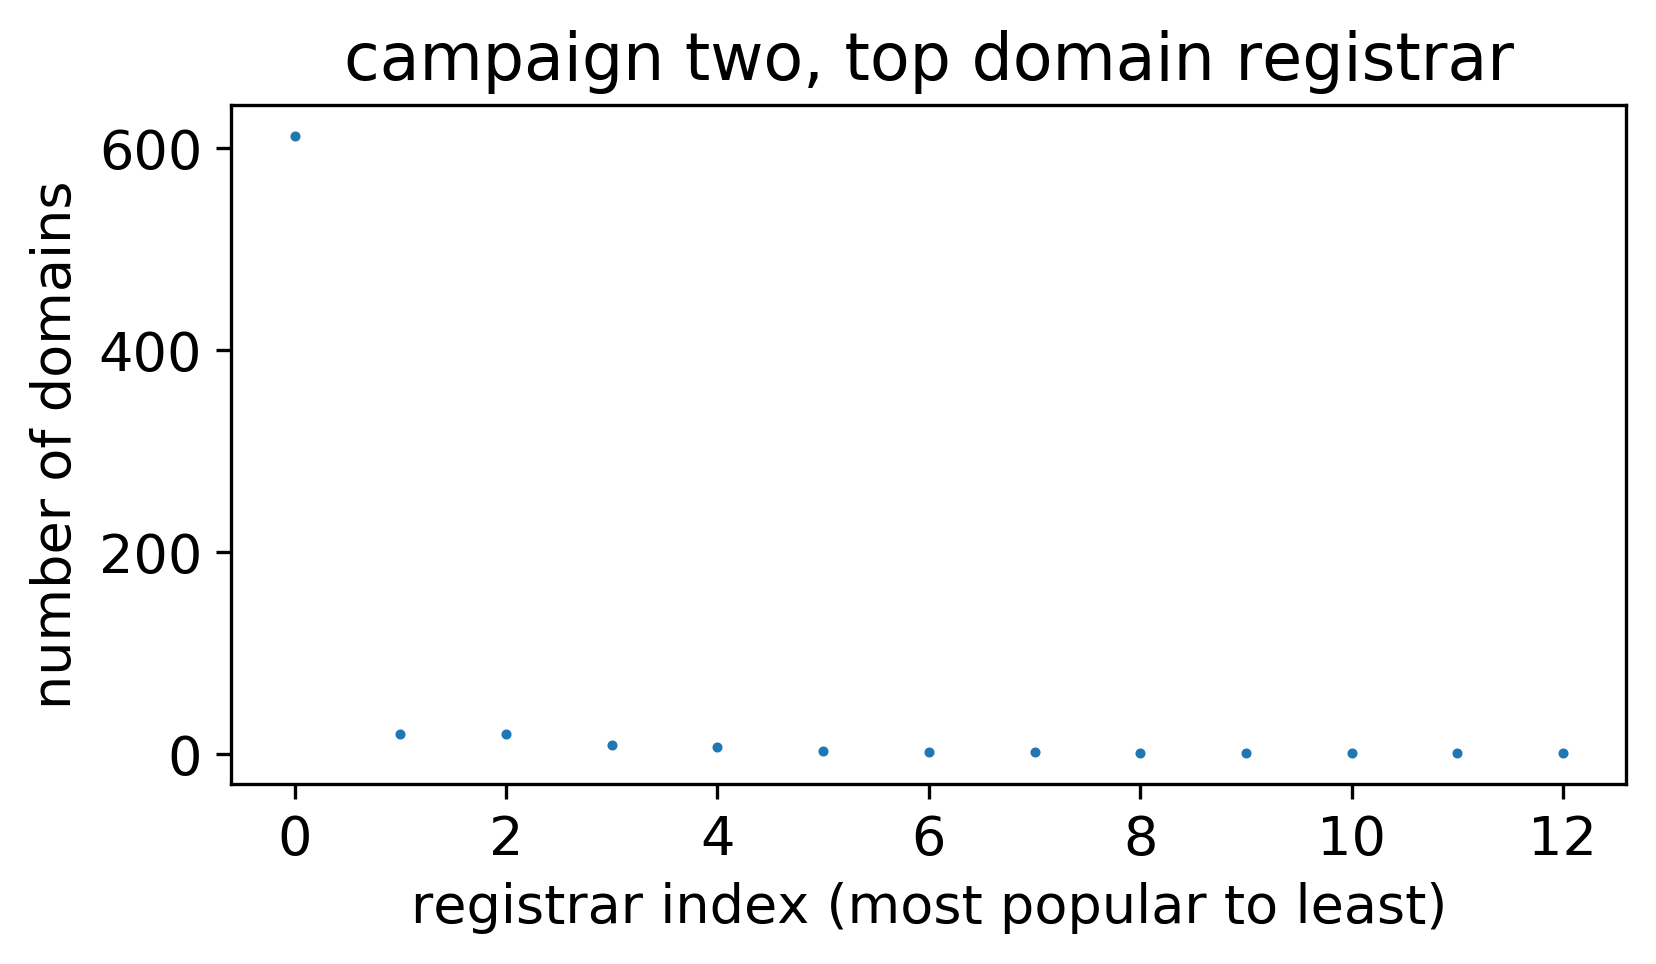

2279
3379
0.6744598993785144


In [113]:
len(whois_record)
# and r['current_whois']['registrant_contact']['full_name'] == 'Jan Everno'  

count_registrar_jan = Counter([(r['current_whois']['domain_registrar']['registrar_name']) for r in whois_record if r['campaign_id'] == 3 and 'registrant_contact' in r['current_whois'] and 'full_name' in r['current_whois']['registrant_contact'] and r['current_whois']['registrant_contact']['full_name'] == 'Jan Everno'])
frequency_jan = [i[1] for i in count_registrar_jan.most_common()]

count_registrar_3 = Counter([(r['current_whois']['domain_registrar']['registrar_name']) for r in whois_record if r['campaign_id'] == 3 and 'domain_registrar' in r['current_whois'] ])
frequency_3 = [i[1] for i in count_registrar_3.most_common()]

count_registrar_2 = Counter([(r['current_whois']['domain_registrar']['registrar_name']) for r in whois_record if r['campaign_id'] == 2 and 'domain_registrar' in r['current_whois']])
frequency_2 = [i[1] for i in count_registrar_2.most_common()]

# plt.figure(figsize=(14, 20))
plt.rcParams.update({'font.size': 13})
# plt.hist(frequency_jan, bins=100)
plt.scatter(range(len(frequency_jan)), frequency_jan, s=2)
plt.title('campaign three [Jan Everno only], top domain registrar')
plt.xlabel('registrar index (most popular to least)')
plt.ylabel('number of domains')
plt.savefig('histogram_registrar_name_campaign_three_jan_everno', dpi=600, bbox_inches = 'tight')
plt.show()
plt.close()

plt.rcParams.update({'font.size': 13})
# plt.hist(frequency_3, bins=100)
plt.scatter(range(len(frequency_3)), frequency_3, s=2)
plt.title('campaign three, top domain registrar')
plt.xlabel('registrar index (most popular to least)')
plt.ylabel('number of domains')
plt.savefig('histogram_registrar_name_campaign_three', dpi=600, bbox_inches = 'tight')
plt.show()
plt.close()

plt.rcParams.update({'font.size': 13})
# plt.hist(frequency_2, bins=100)
plt.scatter(range(len(frequency_2)), frequency_2, s=2)
plt.title('campaign two, top domain registrar')
plt.xlabel('registrar index (most popular to least)')
plt.ylabel('number of domains')
plt.savefig('histogram_registrar_name_campaign_two', dpi=600, bbox_inches = 'tight')
plt.show()

print(sum(frequency_jan))
print(sum([1 for r in whois_record if r['campaign_id'] == 3]))
print(sum(frequency_jan) / sum([1 for r in whois_record if r['campaign_id'] == 3]))

# cc = Counter([r['historical_whois'][0]['Company'] for r in whois_record if r['campaign_id'] == 3 and r['historical_whois'] and 'Company' in r['historical_whois'][0]])
# cc.most_common()

# Company, Owner
# pprint(whois_record[103])
# whois_record



In [43]:
names = [(r['current_whois']['registrant_contact']['full_name']) for r in whois_record if r['campaign_id'] == 3 if 'registrant_contact' in r['current_whois'] and 'full_name' in r['current_whois']['registrant_contact']]
names = [n if 'Savvy' not in n else 'Savvy Investments' for n in names ]
count_full_name = Counter(names)
pprint(count_full_name.most_common())


jan_everno_domain = [r['domain'] for r in whois_record if r['campaign_id'] == 3 and 'registrant_contact' in r['current_whois'] and 'full_name' in r['current_whois']['registrant_contact'] and r['current_whois']['registrant_contact']['full_name'] == 'Jan Everno']


# [(r['current_whois']) for r in whois_record if r['campaign_id'] == 3 if 'domain_registrar' in r['current_whois'] and r['current_whois']['domain_registrar']['registrar_name'] == 'Media Elite Holdings Limited']
# 'Media Elite Holdings Limited'

[('Jan Everno', 2279),
 ('PERFECT PRIVACY, LLC', 168),
 ('Domain Administrator', 165),
 ('Savvy Investments', 148),
 ('The Management Group II', 33),
 ('Anthonny', 19),
 ('REDACTED FOR PRIVACY', 15),
 ('Registration Private', 12),
 ('Domain Admin', 11),
 ('Above Privacy', 4),
 ('RENT DOMAIN LIMITED', 4),
 ('GrandesDominios.com (domain deposited for its sale)', 2),
 ('WPH', 2),
 ('Mohammad Hajebrahimi', 2),
 ('Not disclosed Not disclosed', 1),
 ('MIKE  JAMESON', 1),
 ('Cong Ty TNHH Cong Nghe Nhiet Va Khi Nen', 1),
 ('This domain was caught by DropCatch.com', 1),
 ('DotMedia Limited', 1),
 ('Unilever', 1),
 ('Sohail Qamar', 1),
 ('Spitali  Mendes Representacoes e Servicos Ltda', 1),
 ('Ch Shafaqat Ali', 1),
 ('Kamolpan  Lertvijitsakul', 1),
 ('WhoisGuard Protected', 1),
 ('sayesun', 1),
 ('AZARANWEB Corporate', 1),
 ('Contact Privacy Inc. Customer 0144990443', 1),
 ('Contact Privacy Inc. Customer 0132568841', 1),
 ('SelcukluNet internet hizmetleri ALBATROS Bilgisayar', 1),
 ('Contact Pri

In [32]:
Counter([entry[1][1][0] for entry in domain_2 if len(entry[1]) > 1 and entry[1][1][-1] == 'Deleted']).most_common(20)


[('DOMAINCONTROL.COM', 108),
 ('NAME-SERVICES.COM', 69),
 ('FOUNDATIONAPI.COM', 39),
 ('RENEWYOURNAME.NET', 14),
 ('ONLINENIC.NET', 12),
 ('CLOUDFLARE.COM', 12),
 ('REGISTRAR-SERVERS.COM', 12),
 ('WEBNIC.CC', 10),
 ('REG.RU', 9),
 ('ZTOMY.COM', 8),
 ('NS36.DE', 7),
 ('TOPDNS.ME', 7),
 ('DYNADOT.COM', 7),
 ('HOSTGATOR.COM', 7),
 ('NAME.COM', 6),
 ('IBSPARK.COM', 5),
 ('WORDPRESS.COM', 5),
 ('NAMEBRIGHTDNS.COM', 5),
 ('TLDPARKED.COM', 5),
 ('YOURSRS.COM', 5)]

In [76]:
web_record = []
with jsonlines.open('/Users/zc/Documents/TwitterBotProject/suspicious_domain_web_archive.jsonl') as reader:
    for index, obj in enumerate(reader):
        if index % 100 == 0:
            print(index)
        
        if obj['url'] not in domain_dns_change_time:
            print(obj['url'] + ' is not in dns dictionary')
            continue
            
        num_record = sum([1 for rec in obj['record'] if rec[3] < domain_dns_change_time[obj['url']]])
        web_record.append({
            'campaign_id': obj['campaign_id'],
            'num_record': num_record,
            'domain': obj['url']
        })

#     web_record = [obj for obj in reader]

# web_record

0
maganewspaper2020.pro is not in dns dictionary
wausaucraigslist.com is not in dns dictionary
100
swblife.com is not in dns dictionary
200
showmazika.com is not in dns dictionary
proxy123.net is not in dns dictionary
300
pakprogram.com is not in dns dictionary
oahucraigslist.com is not in dns dictionary
netzeero.com is not in dns dictionary
mmarca.com is not in dns dictionary
400
keepmymail.com is not in dns dictionary
ios-wiki.com is not in dns dictionary
invest-trucking.com is not in dns dictionary
interiortime.com is not in dns dictionary
iclaod.com is not in dns dictionary
500
freehorsexxx.com is not in dns dictionary
eroanimeittyokusen.com is not in dns dictionary
dsspros.com is not in dns dictionary
600
christianlouboutinoutlet.com is not in dns dictionary
cheesypinoy.com is not in dns dictionary
cbtrampling.com is not in dns dictionary
bzupages.net is not in dns dictionary
boprivate.com is not in dns dictionary
700
backlessblouse.com is not in dns dictionary
attnet.net is not i

rajputenterprises.com is not in dns dictionary
radyo17.com is not in dns dictionary
rachacafe.com is not in dns dictionary
qzdlou.com is not in dns dictionary
qypled.com is not in dns dictionary
qurrycrushingmachineschina.com is not in dns dictionary
quickken.com is not in dns dictionary
2000
querocasa.com is not in dns dictionary
queenslandlawyers.com.au is not in dns dictionary
queenslanddrones.com.au is not in dns dictionary
queenbeetch.com is not in dns dictionary
quangcaodonguyen.com is not in dns dictionary
qteccons.com is not in dns dictionary
qornhub.com is not in dns dictionary
qmet-sol.com is not in dns dictionary
qianhaitec.com is not in dns dictionary
qblabantigua.com is not in dns dictionary
pwraffiliates.com is not in dns dictionary
punjabstatelottery.com is not in dns dictionary
puertasyventanasdealuminiodienat.com is not in dns dictionary
publicistas.com is not in dns dictionary
psychologist.net.au is not in dns dictionary
prostatecancer.com.au is not in dns dictionary


freesankyu.com is not in dns dictionary
freelolo.com is not in dns dictionary
freecbtc.com is not in dns dictionary
free-beading-patterns.com is not in dns dictionary
fourlinespreschool.com is not in dns dictionary
forwardrent.com is not in dns dictionary
forsaleturkey.com is not in dns dictionary
forgetselfies.com is not in dns dictionary
ford-binhduong.com is not in dns dictionary
fomprog.com is not in dns dictionary
foaltrain.com is not in dns dictionary
floodinsure.com.au is not in dns dictionary
fletcherdodge.com is not in dns dictionary
flashmobparts.com is not in dns dictionary
3600
flashgameshunter.com is not in dns dictionary
flalottary.com is not in dns dictionary
firsttennesse.com is not in dns dictionary
fioxnews.com is not in dns dictionary
finnsfinds.com is not in dns dictionary
finalcut.com.au is not in dns dictionary
filmbelli.net is not in dns dictionary
fc2just.com is not in dns dictionary
fateofkpop.tv is not in dns dictionary
faryabpt.com is not in dns dictionary
fa

[(('New', 'Deleted'), 530),
 (('Transfer', 'New'), 119),
 (('Transfer', 'Transfer'), 78)]
[(('ABOVE.COM', 'N/A'), 530),
 (('ABOVE.COM', 'BODIS.COM'), 55),
 (('ABOVE.COM', 'PARKINGCREW.NET'), 32),
 (('ABOVE.COM', 'JINMI.COM'), 25),
 (('ABOVE.COM', 'DSREDIRECTION.COM'), 21),
 (('ABOVE.COM', 'NAMEBRIGHTDNS.COM'), 16),
 (('ABOVE.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('ABOVE.COM', 'XZ.COM'), 8),
 (('ABOVE.COM', 'KQW.COM'), 8),
 (('ABOVE.COM', 'FASTDOMAIN.COM'), 3),
 (('ABOVE.COM', 'DRAGONPARKING.COM'), 3),
 (('ABOVE.COM', 'SERVERSEASY.NET'), 1),
 (('ABOVE.COM', 'MOCHAHOST.COM'), 1),
 (('ABOVE.COM', 'A2HOSTING.COM'), 1),
 (('ABOVE.COM', 'HOSTICAN.COM'), 1),
 (('ABOVE.COM', 'HOSTUPON.COM'), 1),
 (('ABOVE.COM', 'HOSTING24.COM'), 1),
 (('ABOVE.COM', 'BLUEHOST.COM'), 1),
 (('ABOVE.COM', 'HOSTEASE.COM'), 1),
 (('ABOVE.COM', 'ANHOSTING.COM'), 1),
 (('ABOVE.COM', 'NAMEPAL.COM'), 1),
 (('ABOVE.COM', 'NDOVERDRIVE.COM'), 1),
 (('ABOVE.COM', 'DYNADOT.COM'), 1),
 (('ABOVE.COM', 'PHEENIXAUCTIONS.COM'), 

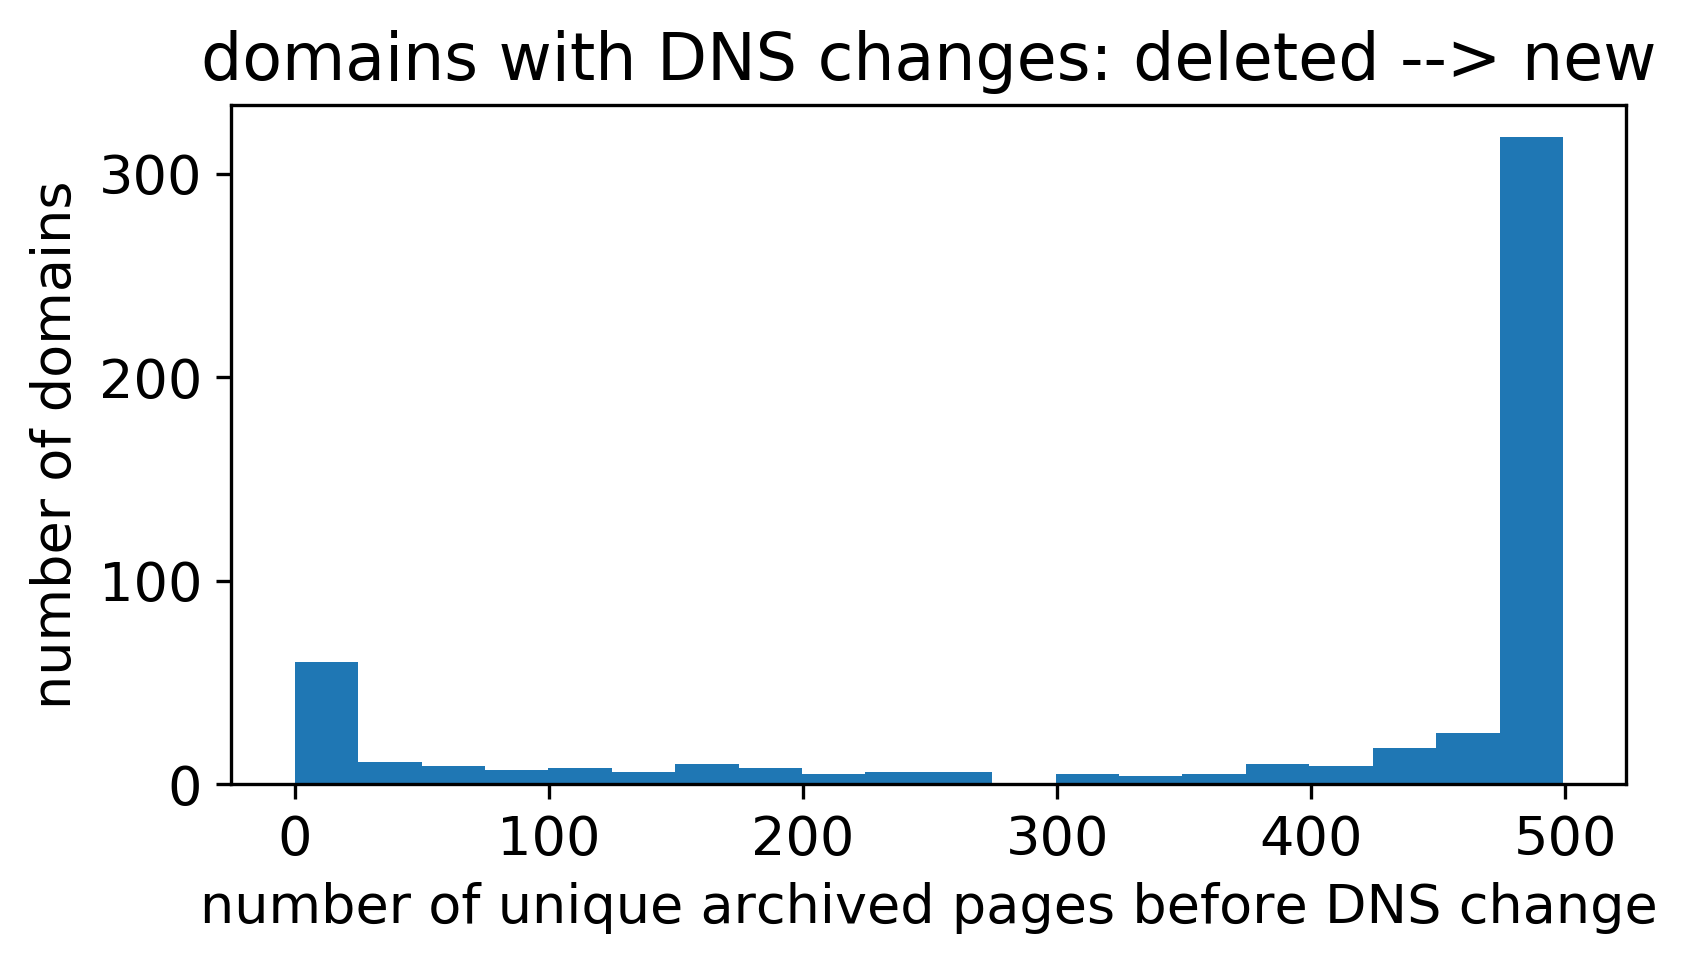

[(('New', 'Deleted'), 530),
 (('Transfer', 'New'), 119),
 (('Transfer', 'Transfer'), 78)]
[(('ABOVE.COM', 'N/A'), 530),
 (('ABOVE.COM', 'BODIS.COM'), 55),
 (('ABOVE.COM', 'PARKINGCREW.NET'), 32),
 (('ABOVE.COM', 'JINMI.COM'), 25),
 (('ABOVE.COM', 'DSREDIRECTION.COM'), 21),
 (('ABOVE.COM', 'NAMEBRIGHTDNS.COM'), 16),
 (('ABOVE.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('ABOVE.COM', 'XZ.COM'), 8),
 (('ABOVE.COM', 'KQW.COM'), 8),
 (('ABOVE.COM', 'FASTDOMAIN.COM'), 3),
 (('ABOVE.COM', 'DRAGONPARKING.COM'), 3),
 (('ABOVE.COM', 'SERVERSEASY.NET'), 1),
 (('ABOVE.COM', 'MOCHAHOST.COM'), 1),
 (('ABOVE.COM', 'A2HOSTING.COM'), 1),
 (('ABOVE.COM', 'HOSTICAN.COM'), 1),
 (('ABOVE.COM', 'HOSTUPON.COM'), 1),
 (('ABOVE.COM', 'HOSTING24.COM'), 1),
 (('ABOVE.COM', 'BLUEHOST.COM'), 1),
 (('ABOVE.COM', 'HOSTEASE.COM'), 1),
 (('ABOVE.COM', 'ANHOSTING.COM'), 1),
 (('ABOVE.COM', 'NAMEPAL.COM'), 1),
 (('ABOVE.COM', 'NDOVERDRIVE.COM'), 1),
 (('ABOVE.COM', 'DYNADOT.COM'), 1),
 (('ABOVE.COM', 'PHEENIXAUCTIONS.COM'), 

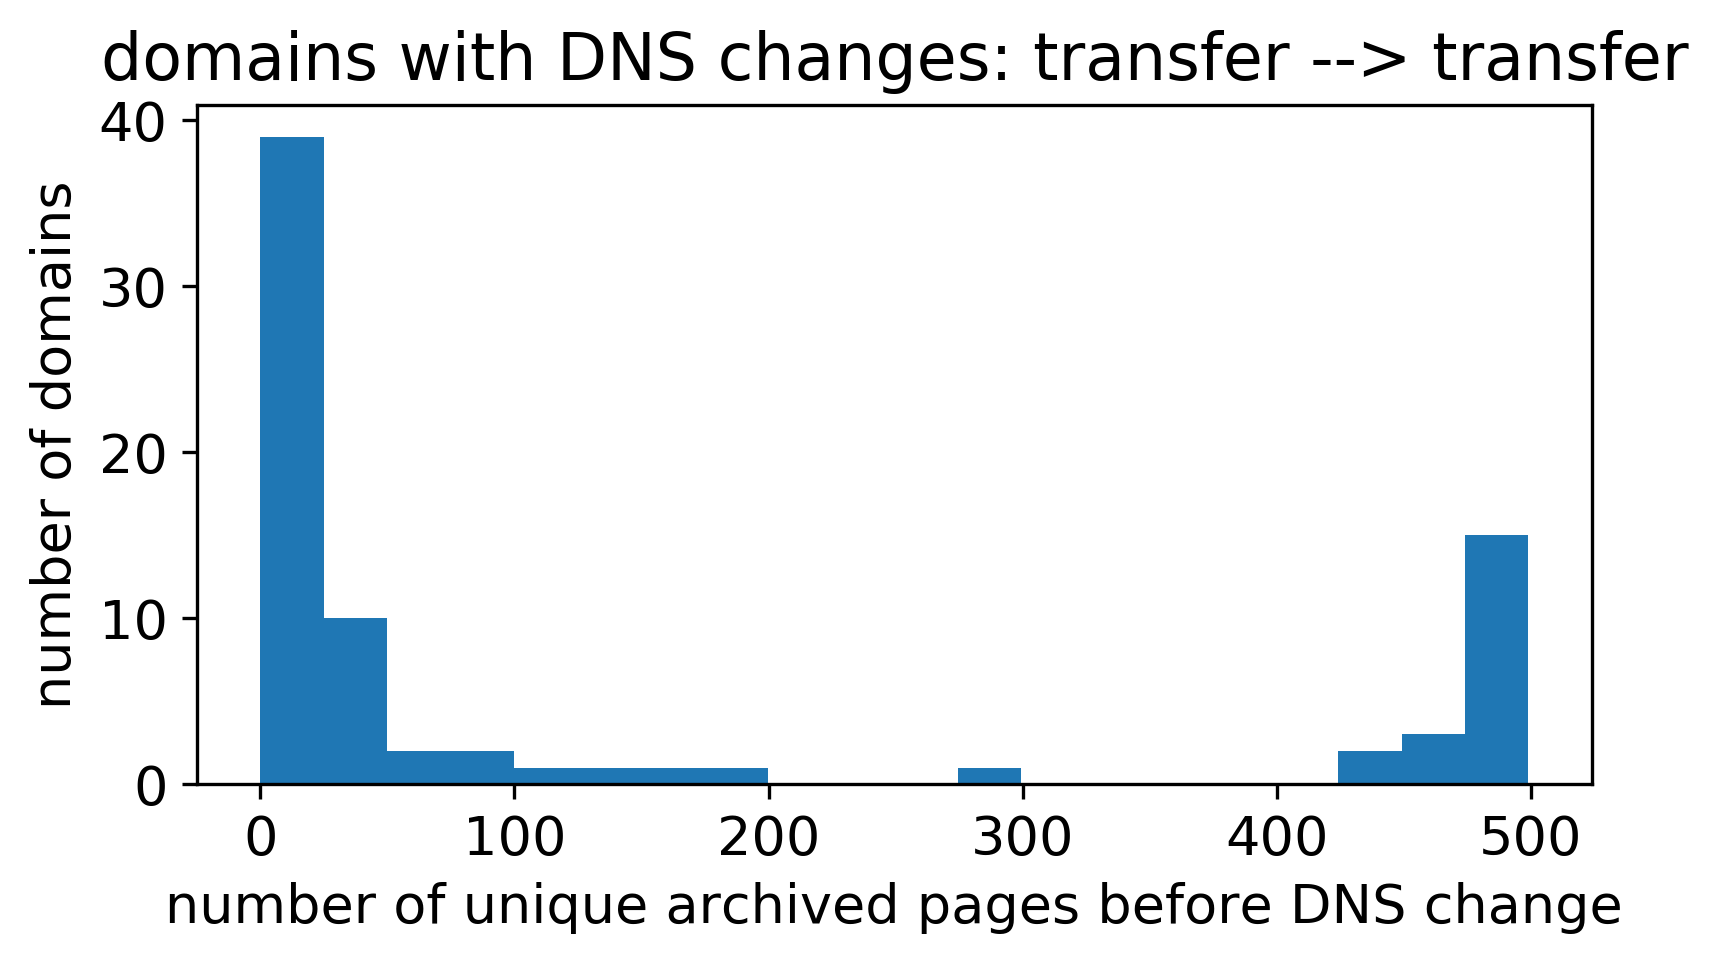

[(('New', 'Deleted'), 530),
 (('Transfer', 'New'), 119),
 (('Transfer', 'Transfer'), 78)]
[(('ABOVE.COM', 'N/A'), 530),
 (('ABOVE.COM', 'BODIS.COM'), 55),
 (('ABOVE.COM', 'PARKINGCREW.NET'), 32),
 (('ABOVE.COM', 'JINMI.COM'), 25),
 (('ABOVE.COM', 'DSREDIRECTION.COM'), 21),
 (('ABOVE.COM', 'NAMEBRIGHTDNS.COM'), 16),
 (('ABOVE.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('ABOVE.COM', 'XZ.COM'), 8),
 (('ABOVE.COM', 'KQW.COM'), 8),
 (('ABOVE.COM', 'FASTDOMAIN.COM'), 3),
 (('ABOVE.COM', 'DRAGONPARKING.COM'), 3),
 (('ABOVE.COM', 'SERVERSEASY.NET'), 1),
 (('ABOVE.COM', 'MOCHAHOST.COM'), 1),
 (('ABOVE.COM', 'A2HOSTING.COM'), 1),
 (('ABOVE.COM', 'HOSTICAN.COM'), 1),
 (('ABOVE.COM', 'HOSTUPON.COM'), 1),
 (('ABOVE.COM', 'HOSTING24.COM'), 1),
 (('ABOVE.COM', 'BLUEHOST.COM'), 1),
 (('ABOVE.COM', 'HOSTEASE.COM'), 1),
 (('ABOVE.COM', 'ANHOSTING.COM'), 1),
 (('ABOVE.COM', 'NAMEPAL.COM'), 1),
 (('ABOVE.COM', 'NDOVERDRIVE.COM'), 1),
 (('ABOVE.COM', 'DYNADOT.COM'), 1),
 (('ABOVE.COM', 'PHEENIXAUCTIONS.COM'), 

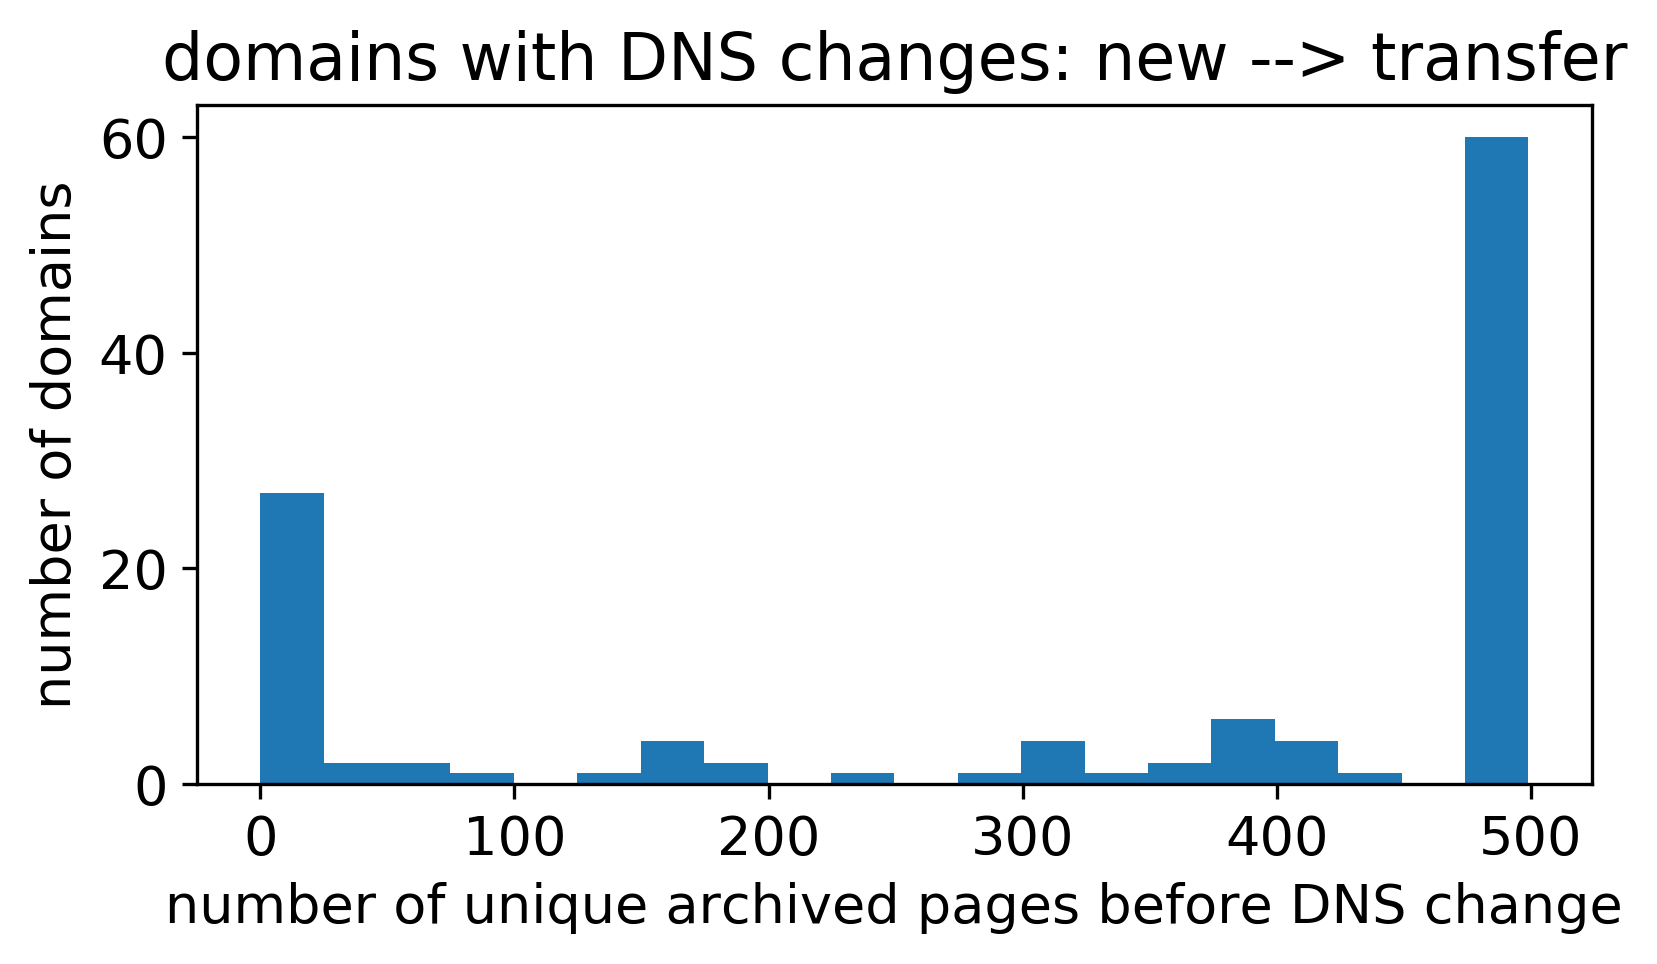

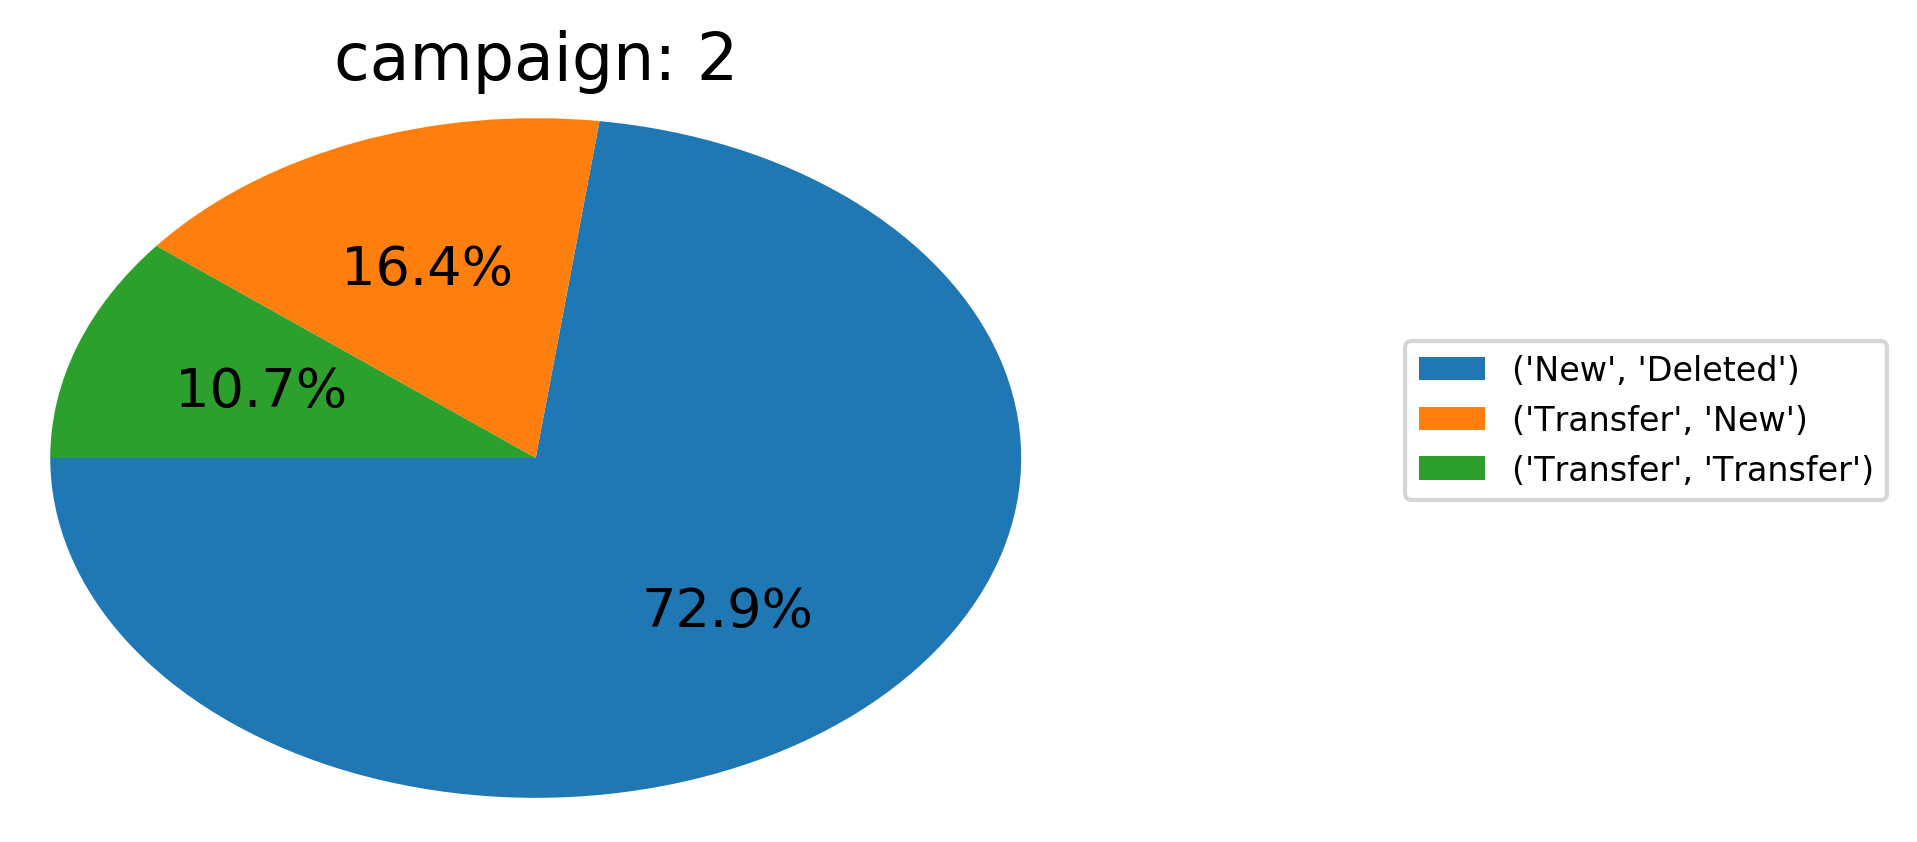

In [98]:
domain_transfer = None

plt.rcParams['figure.figsize'] = [5*1.2, 3]
def web_archive_by_dns_change(domain_input, campaign_id):
#     plt.figure(figsize=(7, 2))
    campaign_domain_to_num = {}
    for rec in web_record:
        if rec['campaign_id'] == campaign_id:
            campaign_domain_to_num[rec['domain']] = rec['num_record']

    result = top_sequence(domain_input, return_type='Deleted_New', verbose=False)
    transfer_len = np.array([campaign_domain_to_num[d] for d in result['return_domain']])
    plt.hist(transfer_len, bins=20)
    plt.title('domains with DNS changes: deleted --> new')
    plt.xlabel('number of unique archived pages before DNS change')
    plt.ylabel('number of domains')
    plt.savefig('histogram_domain_status_deleted_new_campaign_{}'.format(campaign_id), 
                bbox_inches = 'tight',
                dpi=600)
    plt.show()
    plt.close()
    
    result = top_sequence(domain_input, return_type='Transfer_Transfer', verbose=False)
    transfer_len = np.array([campaign_domain_to_num[d] for d in result['return_domain']])
    plt.title('domains with DNS changes: transfer --> transfer')
    plt.xlabel('number of unique archived pages before DNS change')
    plt.ylabel('number of domains')
    plt.hist(transfer_len, bins=20)
    plt.savefig('histogram_domain_status_transfer_campaign_{}'.format(campaign_id), 
                bbox_inches = 'tight',
                dpi=600)
    plt.show()
    domain_transfer = result['return_domain']
    plt.close()
    
    result = top_sequence(domain_input, return_type='New_Transfer', verbose=False)
    transfer_len = np.array([campaign_domain_to_num[d] for d in result['return_domain']])
    plt.title('domains with DNS changes: new --> transfer')
    plt.xlabel('number of unique archived pages before DNS change')
    plt.ylabel('number of domains')
    plt.hist(transfer_len, bins=20)
    plt.savefig('histogram_domain_status_new_transfer_campaign_{}'.format(campaign_id), 
                bbox_inches = 'tight',
                dpi=600)
    plt.show()
    domain_transfer = result['return_domain']
    plt.close()
  
    result['status_count'] = [i for i in result['status_count'] if i[0] != ('New', 'N/A')]
    result['status_count'] = sorted(result['status_count'], key=lambda x: x[0])
    labels = [i[0] for i in result['status_count']]
    sizes = [i[1] for i in result['status_count']]
    fig1, ax1 = plt.subplots()
    pie = ax1.pie(sizes, autopct='%1.1f%%', shadow=False, startangle=180, radius=1.2)
    ax1.set_aspect(0.7)
#     ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('campaign: {}'.format(campaign_id))
    plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="center", fontsize=8, 
           bbox_transform=plt.gcf().transFigure)
    plt.tight_layout()
    plt.savefig('pie_chart_domain_status_campaign_{}'.format(campaign_id), 
                bbox_inches = 'tight',
                dpi=600)
    plt.show()
    plt.close()
# plt.show()

web_archive_by_dns_change(domain_2, 2)

# distribution of domains according to DNS status change

[(('New', 'Deleted'), 2714),
 (('Transfer', 'Transfer'), 250),
 (('New', 'N/A'), 13),
 (('Transfer', 'New'), 11)]
[(('DNSNUTS.COM', 'N/A'), 2727),
 (('DNSNUTS.COM', 'FABULOUS.COM'), 97),
 (('DNSNUTS.COM', 'ZTOMY.COM'), 66),
 (('DNSNUTS.COM', 'ABOVE.COM'), 65),
 (('DNSNUTS.COM', 'HASTYDNS.COM'), 12),
 (('DNSNUTS.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('DNSNUTS.COM', 'CHOOKDNS.COM'), 4),
 (('DNSNUTS.COM', 'LAMEDELEGATION.ORG'), 2),
 (('DNSNUTS.COM', 'DNSLINK.COM'), 2),
 (('DNSNUTS.COM', 'NEXT.ORG'), 1),
 (('DNSNUTS.COM', 'MID-2.COM'), 1),
 (('DNSNUTS.COM', 'WOMBATDNS.COM'), 1)]


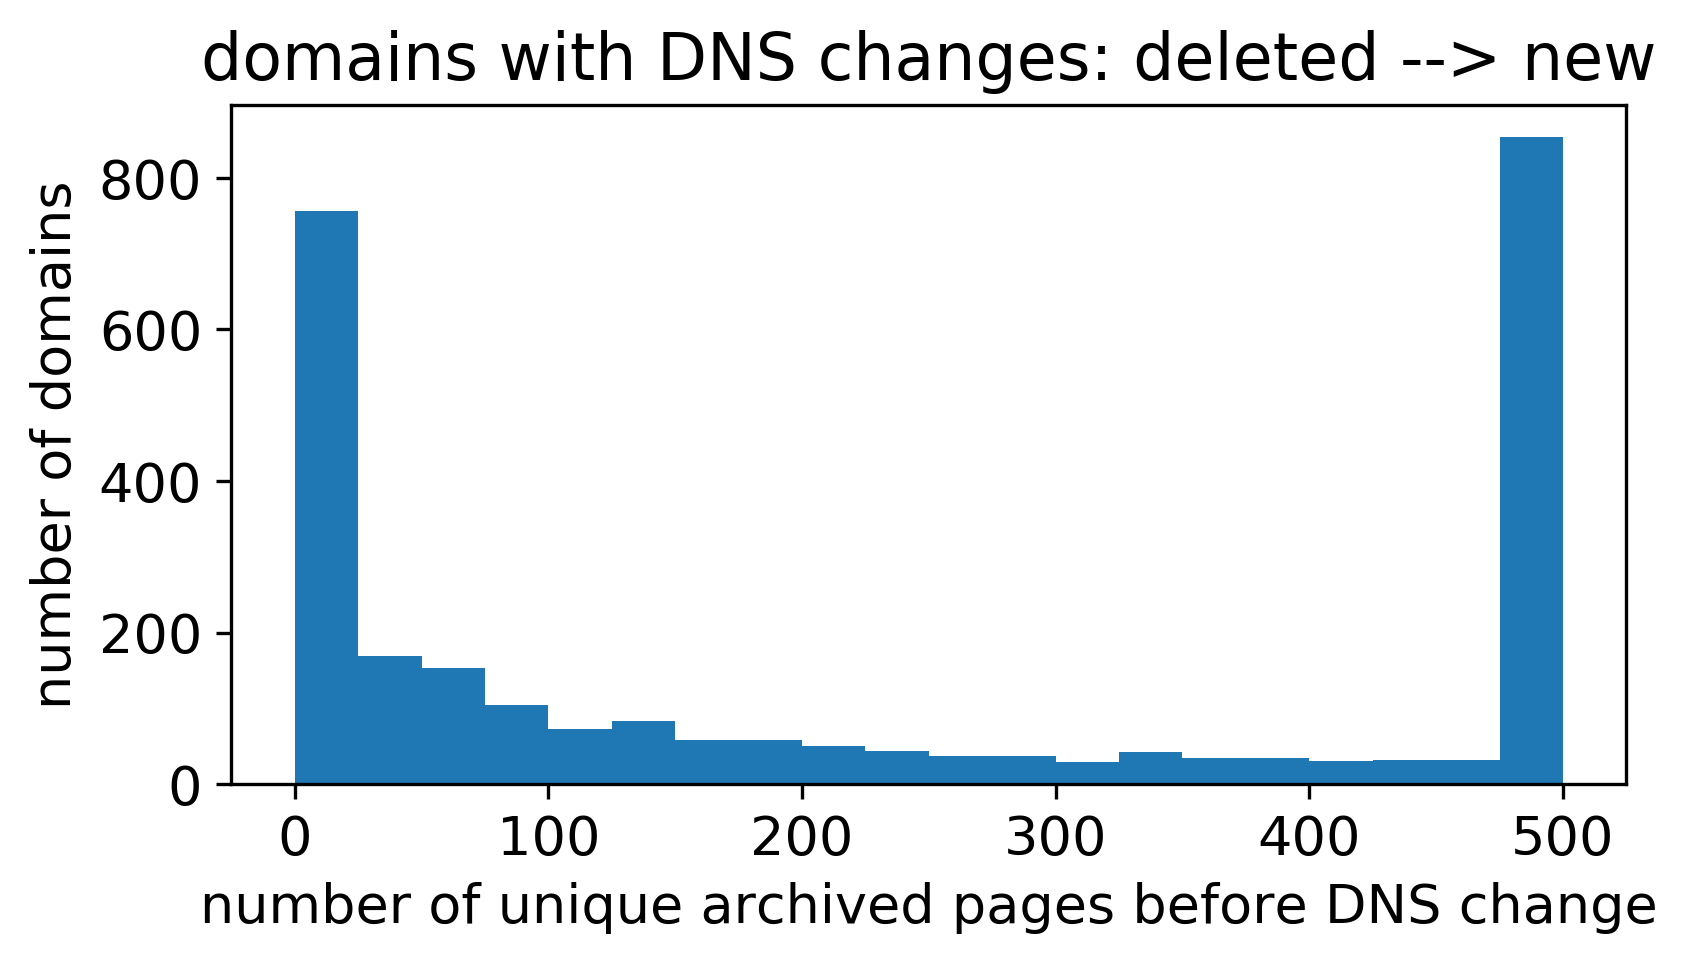

[(('New', 'Deleted'), 2714),
 (('Transfer', 'Transfer'), 250),
 (('New', 'N/A'), 13),
 (('Transfer', 'New'), 11)]
[(('DNSNUTS.COM', 'N/A'), 2727),
 (('DNSNUTS.COM', 'FABULOUS.COM'), 97),
 (('DNSNUTS.COM', 'ZTOMY.COM'), 66),
 (('DNSNUTS.COM', 'ABOVE.COM'), 65),
 (('DNSNUTS.COM', 'HASTYDNS.COM'), 12),
 (('DNSNUTS.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('DNSNUTS.COM', 'CHOOKDNS.COM'), 4),
 (('DNSNUTS.COM', 'LAMEDELEGATION.ORG'), 2),
 (('DNSNUTS.COM', 'DNSLINK.COM'), 2),
 (('DNSNUTS.COM', 'NEXT.ORG'), 1),
 (('DNSNUTS.COM', 'MID-2.COM'), 1),
 (('DNSNUTS.COM', 'WOMBATDNS.COM'), 1)]


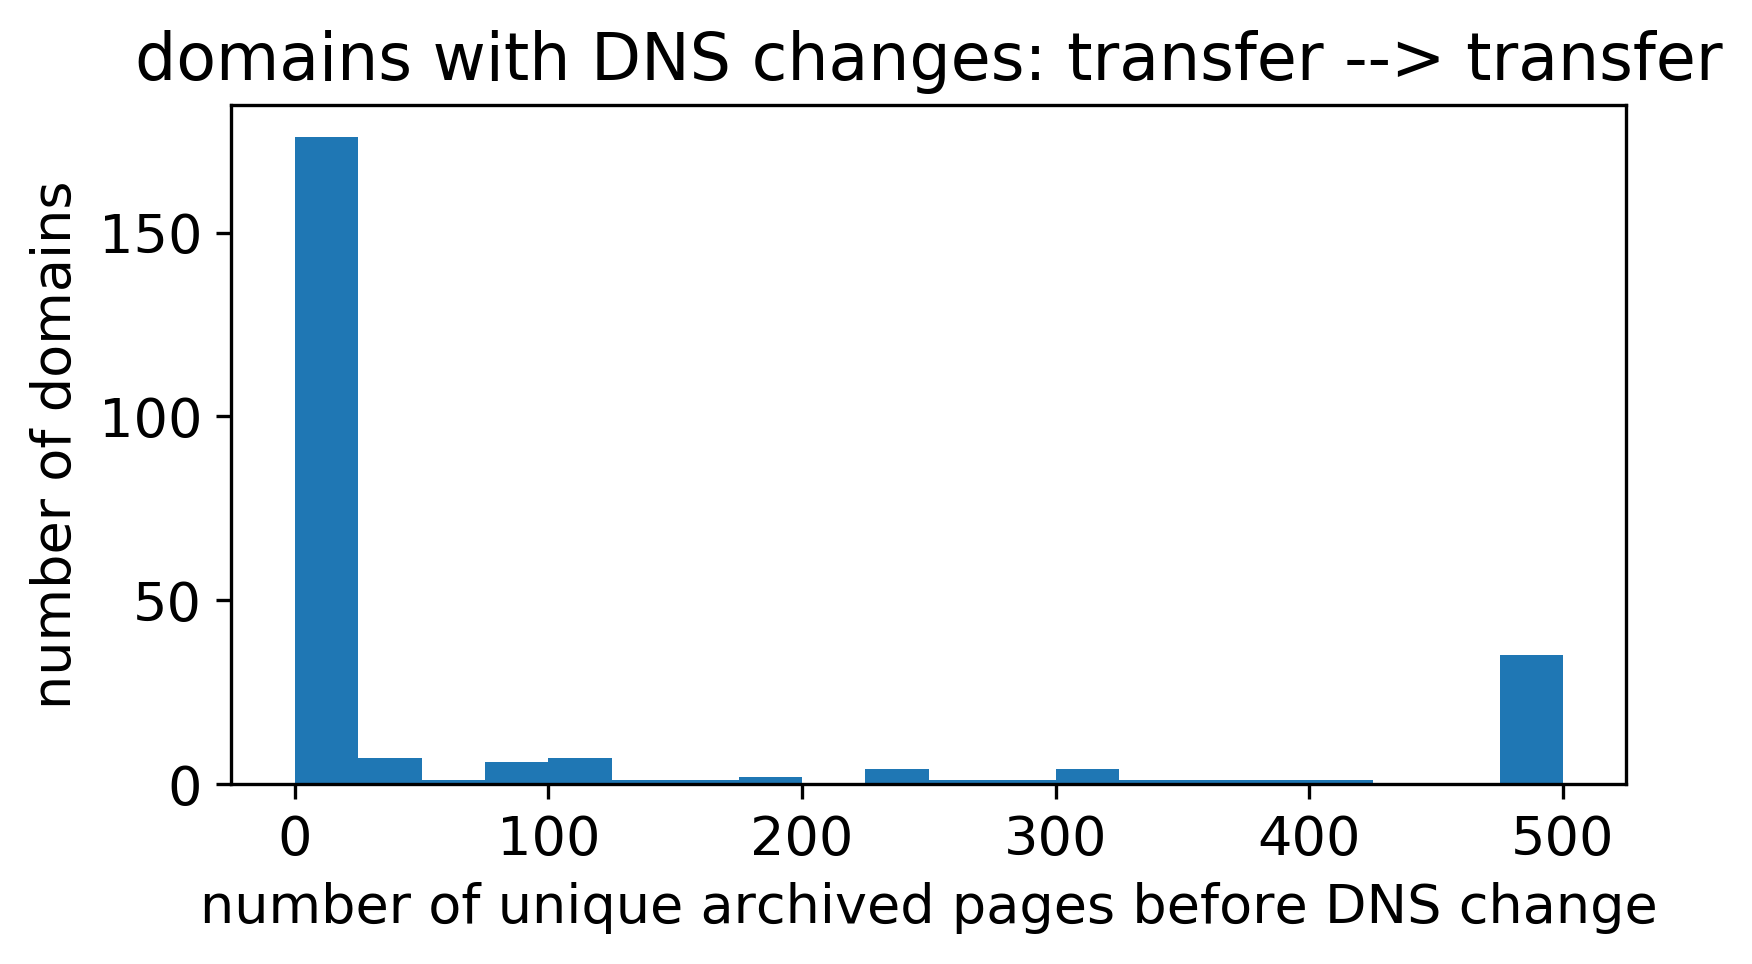

[(('New', 'Deleted'), 2714),
 (('Transfer', 'Transfer'), 250),
 (('New', 'N/A'), 13),
 (('Transfer', 'New'), 11)]
[(('DNSNUTS.COM', 'N/A'), 2727),
 (('DNSNUTS.COM', 'FABULOUS.COM'), 97),
 (('DNSNUTS.COM', 'ZTOMY.COM'), 66),
 (('DNSNUTS.COM', 'ABOVE.COM'), 65),
 (('DNSNUTS.COM', 'HASTYDNS.COM'), 12),
 (('DNSNUTS.COM', 'INTERIMNAMESERVER.COM'), 10),
 (('DNSNUTS.COM', 'CHOOKDNS.COM'), 4),
 (('DNSNUTS.COM', 'LAMEDELEGATION.ORG'), 2),
 (('DNSNUTS.COM', 'DNSLINK.COM'), 2),
 (('DNSNUTS.COM', 'NEXT.ORG'), 1),
 (('DNSNUTS.COM', 'MID-2.COM'), 1),
 (('DNSNUTS.COM', 'WOMBATDNS.COM'), 1)]


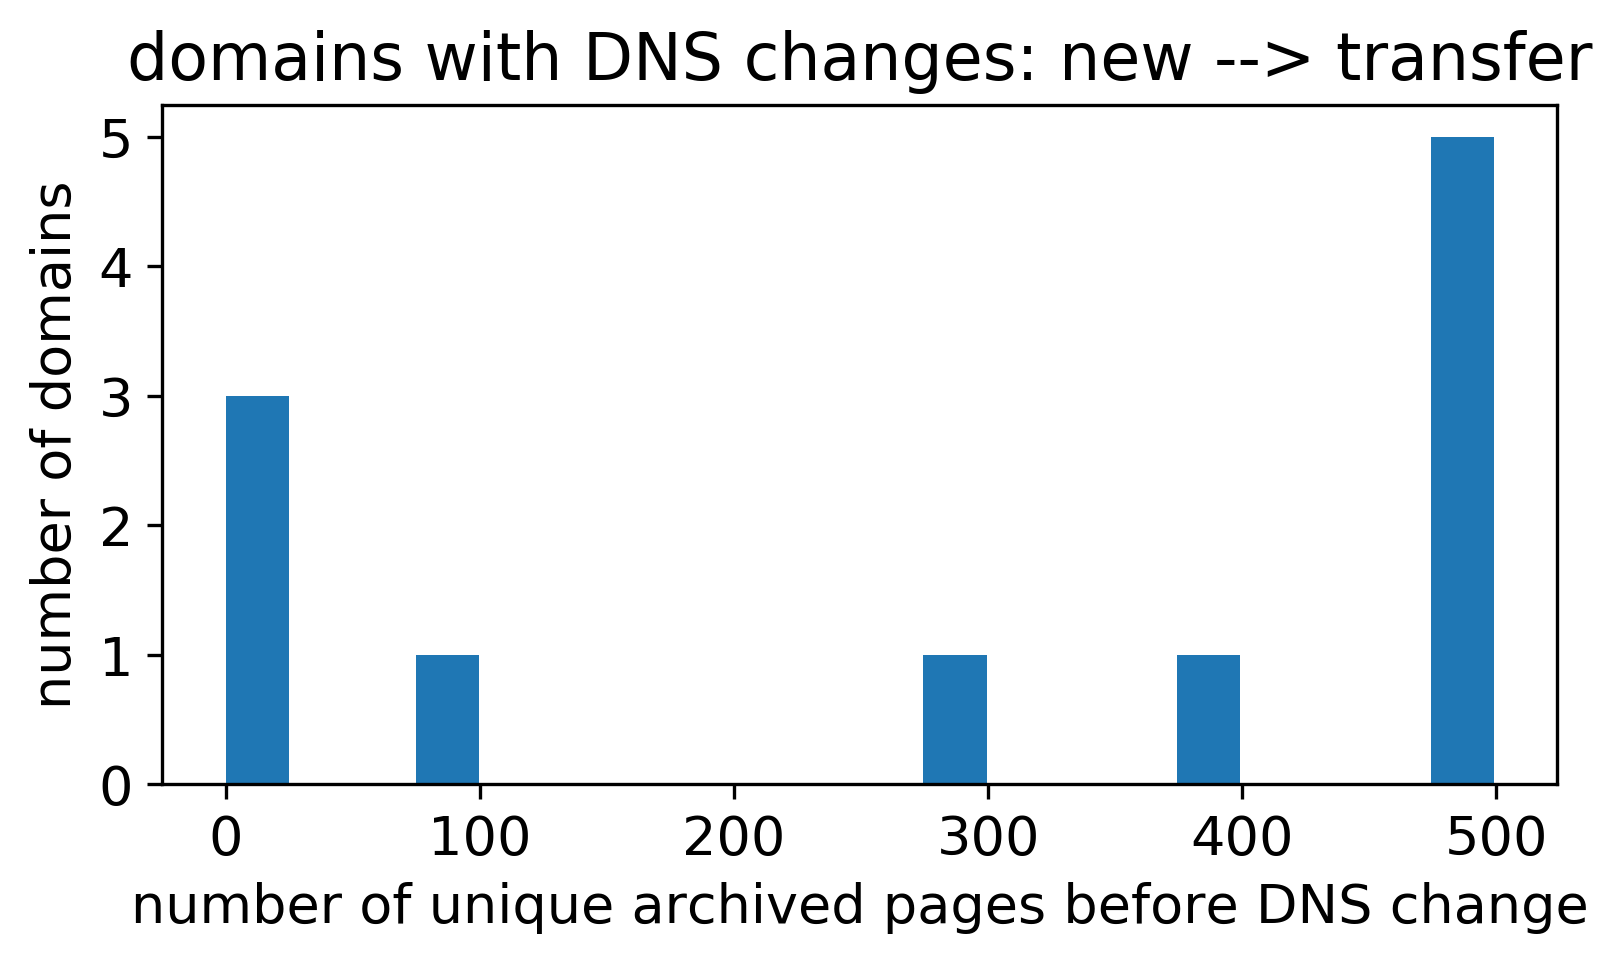

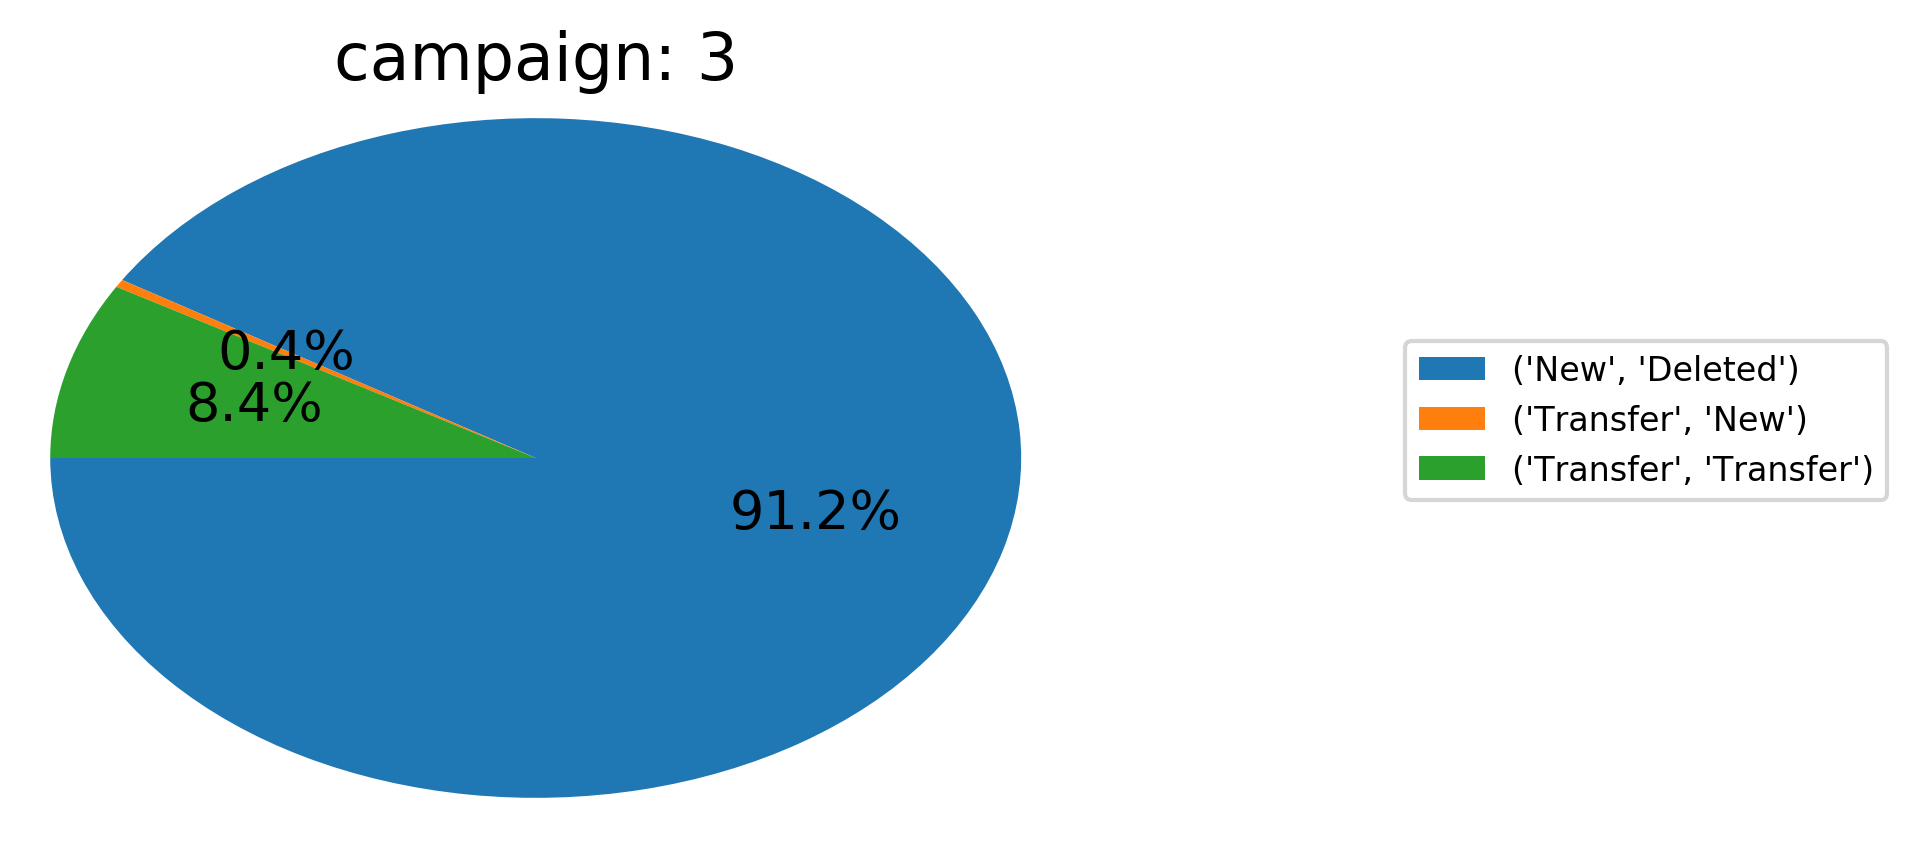

In [99]:
web_archive_by_dns_change(domain_3, 3)

In [82]:
with jsonlines.open('/Users/zc/Documents/TwitterBotProject/suspicious_domain_web_archive.jsonl') as reader:
    num_page_jon = [len(obj['record']) for obj in reader if obj['url'] in jan_everno_domain ]


(array([529., 105.,  82.,  58.,  56.,  68.,  43.,  47.,  38.,  24.,  35.,
         33.,  17.,  29.,  32.,  18.,  26.,  22.,  20.,  15.,  14.,  15.,
         17.,  17.,  10.,  14.,  13.,  16.,  15.,  15.,  13.,  19.,   7.,
          9.,  10.,   8.,   4.,  10.,  11., 745.]),
 array([  0.   ,  12.525,  25.05 ,  37.575,  50.1  ,  62.625,  75.15 ,
         87.675, 100.2  , 112.725, 125.25 , 137.775, 150.3  , 162.825,
        175.35 , 187.875, 200.4  , 212.925, 225.45 , 237.975, 250.5  ,
        263.025, 275.55 , 288.075, 300.6  , 313.125, 325.65 , 338.175,
        350.7  , 363.225, 375.75 , 388.275, 400.8  , 413.325, 425.85 ,
        438.375, 450.9  , 463.425, 475.95 , 488.475, 501.   ]),
 <a list of 40 Patch objects>)

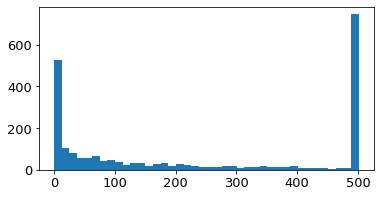

In [83]:
plt.hist(num_page_jon, bins=40)

In [676]:
domain_transfer